In [1]:
import pandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import numpy
import matplotlib.pyplot as plt

2022-05-01 09:07:16.897319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 09:07:16.897337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pandas.read_csv("data.csv", index_col=0)
data.date = pandas.to_datetime(data.date)
print(data.columns)


data = data \
    .drop(["countryOfOrigin", "Category", "Type", "brandId", "trademark", "income"], axis=1) \
    .sort_values("date") \
    .set_index("date")
data.head()

Index(['geoCluster', 'SKU', 'date', 'price', 'sales', 'Category', 'Type',
       'brandId', 'lagerUnitQuantity', 'trademark', 'countryOfOrigin', 'Group',
       'cityId', 'income', 'weekday'],
      dtype='object')


,geoCluster,SKU,price,sales,lagerUnitQuantity,Group,cityId,weekday
date,,,,,,,,
2020-04-04,2120,32485,40.69,25.74,1.0,Tropical fruits,0,5
2020-04-04,2106,32485,39.79,40.61,1.0,Tropical fruits,0,5
2020-04-04,2016,1008,0.00,0.00,0.5,Mineral water,0,5
2020-04-04,2746,32485,40.69,142.57,1.0,Tropical fruits,0,5
2020-04-04,2783,32485,40.69,26.74,1.0,Tropical fruits,0,5


In [3]:
X = data.drop("sales", axis=1)
X.head()

,geoCluster,SKU,price,lagerUnitQuantity,Group,cityId,weekday
date,,,,,,,
2020-04-04,2120,32485,40.69,1.0,Tropical fruits,0,5
2020-04-04,2106,32485,39.79,1.0,Tropical fruits,0,5
2020-04-04,2016,1008,0.00,0.5,Mineral water,0,5
2020-04-04,2746,32485,40.69,1.0,Tropical fruits,0,5
2020-04-04,2783,32485,40.69,1.0,Tropical fruits,0,5


In [4]:
y = data["sales"]

n = data.shape[0]
train_X = X.iloc[0:int(n*.9)]
train_y = y.iloc[0:int(n*.9)]
train_X_idx = train_X.index

test_X = X.iloc[int(n*.9):]
test_y = y.iloc[int(n*.9):]
test_X_idx = test_X.index

train_X.shape, train_y.shape

((4144690, 7), (4144690,))

In [19]:
class Predictor:
    def _create_model(self, input_shape):
        model = keras.Sequential()
        model.add(layers.Dense(16, input_dim=input_shape, activation="relu"))
        model.add(layers.Dense(1, activation="relu"))
        model.compile(loss="mse", optimizer="adam")
        return model
    
    def fit(self, train_X, train_y):        
        self.pipeline = make_pipeline(
            ColumnTransformer(
                transformers=[
                    ("ohe", OneHotEncoder(drop="if_binary", sparse=False), ["Group", "SKU", "weekday"]),
                ],
                remainder="passthrough"
            ),
            StandardScaler()
        )
        self.pipeline.fit(train_X)
        train_X = self.pipeline.transform(train_X)
                      
        self.model = self._create_model(train_X.shape[1])
        return self.model.fit(train_X, train_y,
                              epochs=100, batch_size=1000, verbose=1)
    
    def predict(self, X):
        X = self.pipeline.transform(X)
        pred = self.model.predict(X)
        return numpy.squeeze(pred)


In [20]:
predictor = Predictor()
predictor.fit(train_X, train_y)

Epoch 1/100
4145/4145 [==============================] - 3s 659us/step - loss: 3.9103
Epoch 2/100
4145/4145 [==============================] - 3s 740us/step - loss: 3.6772
Epoch 3/100
4145/4145 [==============================] - 3s 787us/step - loss: 3.6613
Epoch 4/100
4145/4145 [==============================] - 3s 782us/step - loss: 3.6550
Epoch 5/100
4145/4145 [==============================] - 3s 767us/step - loss: 3.6527
Epoch 6/100
4145/4145 [==============================] - 3s 762us/step - loss: 3.6511
Epoch 7/100
4145/4145 [==============================] - 3s 764us/step - loss: 3.6506
Epoch 8/100
4145/4145 [==============================] - 3s 762us/step - loss: 3.6322
Epoch 9/100
4145/4145 [==============================] - 3s 843us/step - loss: 2.9693
Epoch 10/100
4145/4145 [==============================] - 4s 908us/step - loss: 2.9631
Epoch 11/100
4145/4145 [==============================] - 4s 844us/step - loss: 2.9057
Epoch 12/100
4145/4145 [============================

In [21]:
#train_predict = predictor.predict(train_X)
test_predict = predictor.predict(test_X)

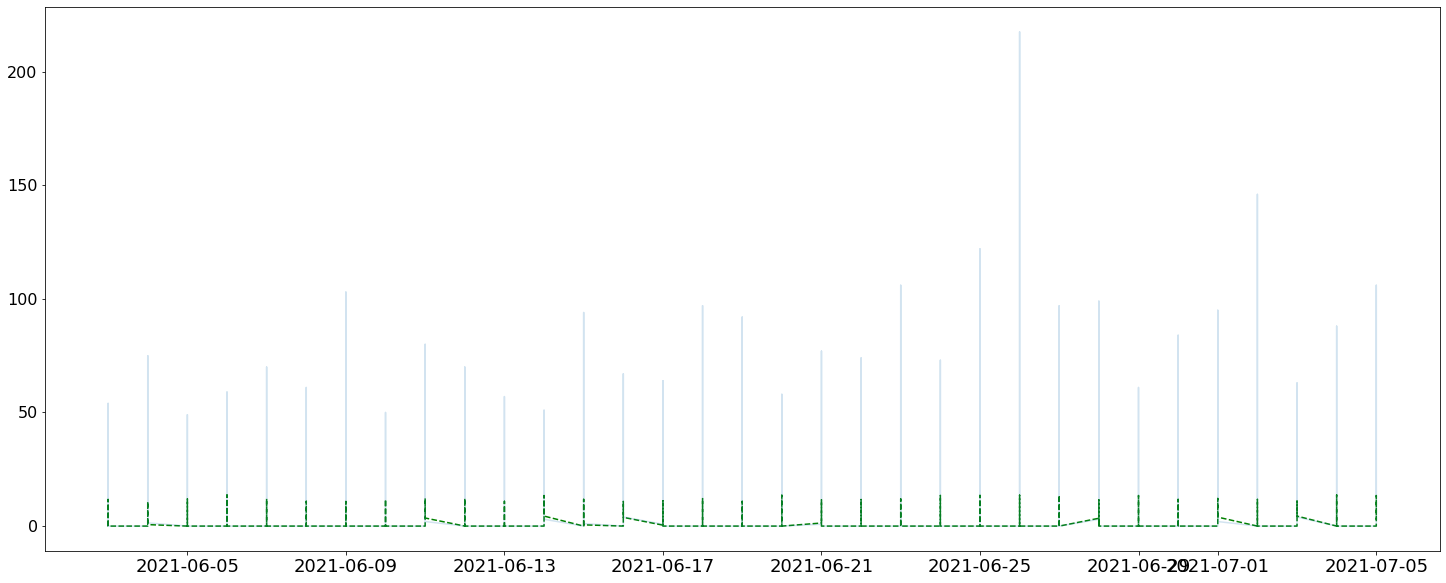

In [22]:
plt.figure(figsize=(25, 10))
#plt.plot(train_X_idx, train_predict, linestyle="dashed")
plt.plot(test_X_idx, test_predict, color="g", linestyle="dashed")

#plt.plot(train_X_idx, train_y, alpha=0.2)
plt.plot(test_X_idx, test_y, alpha=0.2)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

data = pandas.read_csv("data.csv", index_col=0)
data.date = pandas.to_datetime(data.date)
data.head()

totry = data[(data["SKU"] == 32485) & (data["geoCluster"] == 2120)] \
    .reset_index() \
    .sort_values("date") \
    .set_index("date") \
    .drop(["income", "countryOfOrigin", "Category", "Type", "brandId", "trademark"], axis=1)

print(totry.columns)

totryX = totry.drop("sales", axis=1)
totryY = totry["sales"]

totry_pred = predictor.predict(totryX)

plt.figure(figsize=(25, 10))
plt.plot(totryX.index, totry_pred)

plt.plot(totryX.index, totryY, alpha=0.2)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [23]:
import datetime
test_o = pandas.read_csv("Data - Hack UPC/test.csv")
sku = pandas.read_csv("Data - Hack UPC/sku.csv", index_col=0)
geo = pandas.read_csv("Data - Hack UPC/geo_params.csv", index_col=0)

test = test_o.join(sku, on="SKU").join(geo, on="geoCluster")
test.date = pandas.to_datetime(test.date)
test["weekday"] = test.date.dt.day_of_week

test = test \
    .rename({"price_filled": "price"}, axis=1) \
    .reset_index() \
    .sort_values("date") \
    .set_index("date") \
    .drop(["countryOfOrigin", "Category", "Type", "brandId", "trademark", "sales"], axis=1)

print(test.columns)

test_pred = predictor.predict(test)
test_o["sales"] = test_pred
test_o.to_csv("results/prediction__{}.csv".format(datetime.datetime.now()))

Index(['index', 'ID', 'geoCluster', 'SKU', 'price', 'lagerUnitQuantity',
       'Units', 'Group', 'cityId', 'weekday'],
      dtype='object')
